Micro Grid Example
================

## The micro Grid is constituted of:

- a connexion to the main Grid
- a battery
- a PV panel
- a Power load (assumed fixed)


In [1]:
from lms2.electric.batteries import Battery
from lms2.electric.maingrids import MainGrid
from lms2.electric.sources import ScalablePowerSource, PowerLoad
from lms2.core.models import LModel
from lms2.core.time import Time

from pyomo.dae.integral import Integral
from pyomo.dae.contset import ContinuousSet
from pyomo.dae.plugins.finitedifference import TransformationFactory
from pyomo.environ import Objective, SolverFactory

import matplotlib
import matplotlib.pyplot as plt
from lms2.base.utils import pplot
import pandas as pd
import numpy as np

keywords are unexpanded, not using


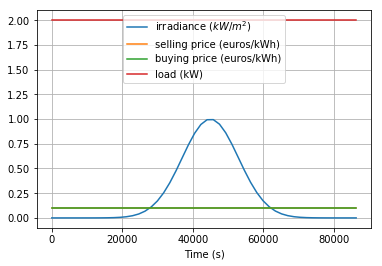

In [2]:
time = np.linspace(0, 86400, num=50, endpoint=True)
sigma = 8000
mu = 45000


def irr(t):
    return np.exp( - (t - 45000)**2 / (2 * sigma**2))


irr  = pd.Series([irr(i) for i in time], index=time)   # Gaussian irradiance (kW/m²)
load = pd.Series({0: 2,   86400: 2})  # constant load of 2 kW
cin  = pd.Series({0: 0.1, 86400: 0.1}) # constant selling price of 0.1 euro/kWh
cout = pd.Series({0: 0.1, 86400: 0.1}) # constant buying price of 0.1 euro/kWh

irr.plot(label='irradiance ($kW/m^2$)')
cin.plot(label='selling price (euros/kWh)')
cout.plot(label='buying price (euros/kWh)')
load.plot(label='load (kW)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

In [3]:
m = LModel(name='model')
t = Time('01-01-2018 00:00:00', '01-02-2018 00:00:00', freq='5min')
m.t = ContinuousSet(bounds=(0, t.delta))

In [4]:
m.bat1  = Battery(time=m.t, e0=100.0, ef=100, emin=10.0, emax=200, etac=0.98, etad=0.98, pcmax=10, pdmax=10)
m.mg    = MainGrid(time=m.t, cin=cin, cout=cout, pmax=6, pmin=6, mixCO2=70)
m.ps    = ScalablePowerSource(time=m.t, profile=irr, flow_name='p')
m.pl    = PowerLoad(time=m.t, profile=load, flow_name='p')

In [5]:
m.connect_flux(m.bat1.p, m.ps.p, m.mg.p, m.pl.p)

## Discretization of the continuous time set 

In [6]:
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(m, wrt=m.t, nfe=t.nfe, scheme='BACKWARD')  # BACKWARD or FORWARD

## Definition of the objectives

In [7]:
def instant_cost(m, t):
    return (m.mg.pout[t] * m.mg.cout[t] - m.mg.pin[t] * m.mg.cin[t])/3600


def power(m,t):
    return (m.mg.pout[t] - m.mg.pin[t])/3600


def instant_prosumation(m,t):
    return (m.mg.pin[t] + m.mg.pout[t])/3600


def instant_co2(m,t):
    return (m.mg.pout[t] - m.mg.pin[t])*m.mg.mixCO2/3600


m.cost   = Integral(m.t, wrt=m.t, rule=instant_cost)
m.co2    = Integral(m.t, wrt=m.t, rule=instant_co2)
m.energy = Integral(m.t, wrt=m.t, rule=power)
m.prosum = Integral(m.t, wrt=m.t, rule=instant_prosumation)



## Examples of modifying the model

1. Change energy price
2. Fix/Unfix PV Panel Surface
3. Activate/Deactivate constraint on Battery final state of charge
4. Selection of Objective (choosing between cost, co2 emmision, energy consumption and prosumtion) 

In [8]:
for i in m.t: 
    m.mg.cout[i].set_value(0.20)   # example of changing buying price
    m.mg.cin[i].set_value(0.15)    # example of changing selling price


m.ps.scale_fact.fix(5)
#m.ps.scale_fact.unfix()

m.bat1._e_final.deactivate()
m.bat1._e_final.activate()

obj = 1 # 2, 3 or 4

try :
    m.del_component('obj')
except:
    pass

if obj == 1:
    m.obj = Objective(expr=m.cost)
elif obj == 2:
    m.obj = Objective(expr=m.co2)
elif obj == 3:
    m.obj = Objective(expr=m.energy)
elif obj == 4:
    m.obj = Objective(expr=m.prosum)
else: 
    raise ValueError('Choose between objectif 1, 2, 3 or 4. ')


### Selection of solver and optimization 

In [14]:
opt = SolverFactory("glpk")
import time
t1 = time.time()
results = opt.solve(m)
t2 = time.time() - t1
print(f'Elapsed time : \t {t2}')

Elapsed time : 	 0.5108118057250977


### Printing results 


Problem: 
- Name: unknown
  Lower bound: 4.08513347684235
  Upper bound: 4.08513347684235
  Number of objectives: 1
  Number of constraints: 3471
  Number of variables: 3469
  Number of nonzeros: 7804
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 149
      Number of created subproblems: 149
  Error rc: 0
  Time: 0.31603026390075684
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



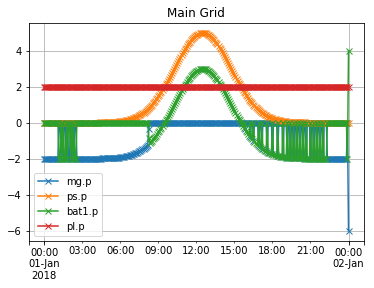

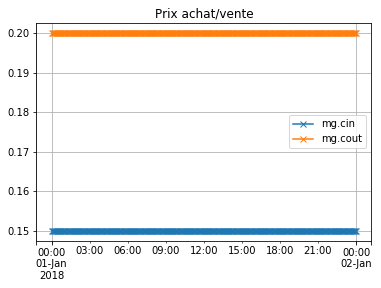

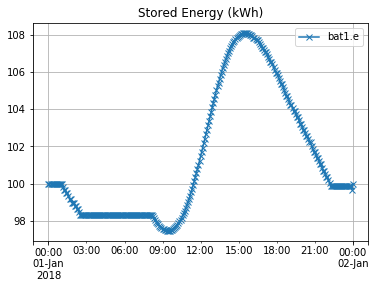

In [10]:
print(results)

pplot(m.mg.p, m.ps.p, m.bat1.p, m.pl.p, index=t.datetime, legend=True, title='Main Grid', Marker='x')
plt.grid(True)
pplot(m.mg.cin, m.mg.cout, index=t.datetime, legend=True, title='Prix achat/vente', Marker='x')
plt.grid(True)
pplot(m.bat1.e, index=t.datetime, legend=True, title='Stored Energy (kWh)', Marker='x')
plt.grid(True)
plt.show()

In [15]:
print(m.ps.scale_fact())
print(m.cost())
print(m.co2()/1000)
print(m.energy())
print(m.prosum())

5
4.085133476842353
1.4297967168948233
20.425667384211756
20.425667384211756
